#Imports and Data Classes for all Parts

In [7]:
#Imports

import time
import os
import random
import types
from matplotlib import pyplot as plt
import torch
from tqdm import tqdm
# -----------------------------------------------------------------
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
# -----------------------------------------------------------------
from torch.utils.data import Dataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
# -----------------------------------------------------------------
!pip install torchmetrics
from torchmetrics import F1Score
from torchmetrics import ConfusionMatrix
from torchmetrics import Accuracy
# -----------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
#Data in CPU for questions 1-5
device="cpu"
print ("device =",device)

device = cpu


In [9]:
#Dataset Class to process our input files for use with the neural network

class dataset(Dataset):
  def __init__(self,data, labels,labels_map,transform=None):
    self.transform = transform
    self.labels = []
    for l in labels:
      self.labels.append(labels_map[l])
    self.labels = np.array(self.labels)
    self.data = data

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, index):
    sound = self.data[index]
    label = self.labels[index]
    if self.transform:
      sound = self.transform(sound)
    return sound, label

labels_map = {
    "classical":0,
    "blues":1,
    "rock_metal_hardrock":2,
    "hiphop":3,
}




# Part 1 Feedforward Neural Network

## Step 1 Load Data

In [11]:

mfcctraindata = np.load('/content/drive/MyDrive/Machine_Learning/music_genre_data_di/train/mfccs/X.npy')
mfcctrainlabels = np.load('/content/drive/MyDrive/Machine_Learning/music_genre_data_di/train/mfccs/labels.npy')

mfcctestdata = np.load('/content/drive/MyDrive/Machine_Learning/music_genre_data_di/test/mfccs/X.npy')
mfcctestlabels = np.load('/content/drive/MyDrive/Machine_Learning/music_genre_data_di/test/mfccs/labels.npy')

mfccvaldata = np.load('/content/drive/MyDrive/Machine_Learning/music_genre_data_di/val/mfccs/X.npy')
mfccvallabels = np.load('/content/drive/MyDrive/Machine_Learning/music_genre_data_di/val/mfccs/labels.npy')


training_data = dataset(mfcctraindata, mfcctrainlabels, labels_map, torch.tensor)
val_data = dataset(mfccvaldata, mfccvallabels, labels_map, torch.tensor)
test_data = dataset(mfcctestdata, mfcctestlabels, labels_map, torch.tensor)


train_dataloader = DataLoader(training_data, batch_size=16,shuffle=True )
val_dataloader =  DataLoader(val_data, batch_size=16,shuffle=True )
test_dataloader =  DataLoader(test_data, batch_size=16,shuffle=False)


In [12]:

def print_first_n_elements(dataloader, n=10):
    count = 0
    for batch in dataloader:
        for i in range(len(batch[0])):
            if count >= n:
                return
            X, y = batch[0][i], batch[1][i]
            print(f"Element {count + 1}")
            print("Input:", X)
            print("Label:", y)
            print()
            count += 1

dataloader = train_dataloader

print_first_n_elements(dataloader, 10)

Element 1
Input: tensor([-22.9744,   1.9012,   0.1679,   0.5512,   0.3211,   0.5997,   0.0674,
          0.0578,   0.0309,   0.0858,   0.2841,   0.4549,   0.1126,   1.2083,
          0.4164,   0.6556,   0.3223,   0.3863,   0.4391,   0.2785,   0.2911,
          0.3201,   0.2940,   0.3278,   0.3299,   0.2015], dtype=torch.float64)
Label: tensor(3)

Element 2
Input: tensor([-2.3234e+01,  1.6790e+00,  8.4396e-01,  5.8634e-01,  3.0448e-01,
         6.4591e-01, -1.8444e-01,  6.9171e-03,  3.0031e-01,  3.9149e-01,
         4.0412e-01, -1.1271e-02, -1.5429e-01,  1.3284e+00,  5.4626e-01,
         3.1021e-01,  4.3165e-01,  2.2652e-01,  2.4103e-01,  3.5091e-01,
         1.9282e-01,  1.9751e-01,  1.8797e-01,  1.9818e-01,  2.0764e-01,
         1.6100e-01], dtype=torch.float64)
Label: tensor(2)

Element 3
Input: tensor([-24.7860,   2.3513,  -2.0920,   0.3254,   0.6009,   0.2253,  -0.3357,
         -0.1756,  -0.4013,  -0.1950,   0.3568,   0.1239,  -0.3383,   0.5490,
          0.4892,   0.4613,   0.300

## Step 2 Fully Connected Neural Network

In [13]:
class NeuralNetwork(nn.Module):
  def __init__(self,activation_function=None):
      super(NeuralNetwork, self).__init__()
      self.layer1 = nn.Linear(26, 128)
      self.layer2 = nn.Linear(128,32)
      self.layer3 = nn.Linear(32,4)
      self.activation_function = activation_function

  def forward(self, x):
    x = self.layer1(x)
    if self.activation_function:
      x = self.activation_function(x)
    x = self.layer2(x)
    if self.activation_function:
      x = self.activation_function(x)
    logits = self.layer3(x)
    return logits
#No activation function in this step
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (layer1): Linear(in_features=26, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=4, bias=True)
)


## Step 3 Training Function

In [14]:
def train(num_epochs, optimizer, dataloader,cost_func,model, device):
  model.to(device)
  model.train()
  size = len(dataloader.dataset)
  for epoch in range(num_epochs):
    print(f"current epoch: {epoch}\n")
    for batch, (X,y) in enumerate(dataloader):
      X = X.to(device)
      y = y.to(device)
      pred = model(X.float())
      loss = cost_func(pred,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
  return model

## Step 4 Evaluation Function


In [15]:
def evaluate(dataloader, cost_func, model, device):
    model.to(device)
    model.eval()

    test_loss = 0.0
    test_f1 = 0.0
    test_acc = 0.0
    correct = 0
    size = len(dataloader.dataset)
    accuracy = Accuracy(task="multiclass", num_classes=4).to(device)
    f1 = F1Score(task="multiclass", num_classes=4, average="macro").to(device)
    confmatrix = ConfusionMatrix(task="multiclass", num_classes=4).to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device).float()
            y = y.to(device)

            pred = model(X)

            all_preds.append(pred)
            all_labels.append(y)

            test_loss += cost_func(pred, y).item() * X.size(0)
            test_acc += accuracy(pred, y).item() * X.size(0)
            test_f1 += f1(pred, y).item() * X.size(0)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    test_acc /= size
    test_f1 /= size

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    confusion_matrix = confmatrix(all_preds.argmax(dim=1), all_labels)

    print(f"Avg Accuracy: {100*test_acc:>8f}%, Avg loss: {test_loss:>8f}")
    print(f"F1 score is: {test_f1}")
    print("Confusion Matrix:")
    print(confusion_matrix.cpu().numpy())

    return test_loss, test_f1, test_acc, confusion_matrix


## Step 5 Training and Evaluation of our Model

In [16]:
device = "cpu"
model = NeuralNetwork().to(device)
cost_func = nn.CrossEntropyLoss()
learning_rate = 0.002
num_epochs = 30
batch_size = 16
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
start_time = time.time()
model = train(num_epochs, optimizer, train_dataloader,cost_func,model,device)
print(f"\nTotal Time for Training in CPU: {time.time() - start_time}")
test_loss, test_f1, test_acc, confmatrix = evaluate(val_dataloader, cost_func, model,device)

Streaming output truncated to the last 5000 lines.
loss: 1.344077  [  912/ 3200]
loss: 1.227578  [  928/ 3200]
loss: 1.304826  [  944/ 3200]
loss: 1.306929  [  960/ 3200]
loss: 1.316983  [  976/ 3200]
loss: 1.302292  [  992/ 3200]
loss: 1.300383  [ 1008/ 3200]
loss: 1.238822  [ 1024/ 3200]
loss: 1.282813  [ 1040/ 3200]
loss: 1.195735  [ 1056/ 3200]
loss: 1.332905  [ 1072/ 3200]
loss: 1.325178  [ 1088/ 3200]
loss: 1.304537  [ 1104/ 3200]
loss: 1.204636  [ 1120/ 3200]
loss: 1.235811  [ 1136/ 3200]
loss: 1.425579  [ 1152/ 3200]
loss: 1.320343  [ 1168/ 3200]
loss: 1.321758  [ 1184/ 3200]
loss: 1.341453  [ 1200/ 3200]
loss: 1.296938  [ 1216/ 3200]
loss: 1.315947  [ 1232/ 3200]
loss: 1.327361  [ 1248/ 3200]
loss: 1.267840  [ 1264/ 3200]
loss: 1.296741  [ 1280/ 3200]
loss: 1.210579  [ 1296/ 3200]
loss: 1.363716  [ 1312/ 3200]
loss: 1.292179  [ 1328/ 3200]
loss: 1.378983  [ 1344/ 3200]
loss: 1.253724  [ 1360/ 3200]
loss: 1.353701  [ 1376/ 3200]
loss: 1.304173  [ 1392/ 3200]
loss: 1.285486  [ 1

## Step 6 Comparing Processing Time against GPU

In [17]:
if torch.cuda.is_available():
  device="cuda"
print("device=", device)


model = NeuralNetwork().to(device)
cost_func = nn.CrossEntropyLoss()
learning_rate = 0.002
num_epochs = 30
batch_size = 16
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
start_time = time.time()
model = train(num_epochs, optimizer, train_dataloader,cost_func,model,device)
print(f"\nTotal Time for Training in GPU: {time.time() - start_time}")
test_loss, test_f1, test_acc, confmatrix = evaluate(val_dataloader, cost_func, model,device)

Streaming output truncated to the last 5000 lines.
loss: 1.245351  [  912/ 3200]
loss: 1.275699  [  928/ 3200]
loss: 1.349842  [  944/ 3200]
loss: 1.329913  [  960/ 3200]
loss: 1.250380  [  976/ 3200]
loss: 1.356080  [  992/ 3200]
loss: 1.286289  [ 1008/ 3200]
loss: 1.282448  [ 1024/ 3200]
loss: 1.284261  [ 1040/ 3200]
loss: 1.312157  [ 1056/ 3200]
loss: 1.331797  [ 1072/ 3200]
loss: 1.268752  [ 1088/ 3200]
loss: 1.269939  [ 1104/ 3200]
loss: 1.294107  [ 1120/ 3200]
loss: 1.265244  [ 1136/ 3200]
loss: 1.345123  [ 1152/ 3200]
loss: 1.325344  [ 1168/ 3200]
loss: 1.253829  [ 1184/ 3200]
loss: 1.369187  [ 1200/ 3200]
loss: 1.307675  [ 1216/ 3200]
loss: 1.316044  [ 1232/ 3200]
loss: 1.218068  [ 1248/ 3200]
loss: 1.319752  [ 1264/ 3200]
loss: 1.273467  [ 1280/ 3200]
loss: 1.235621  [ 1296/ 3200]
loss: 1.336444  [ 1312/ 3200]
loss: 1.321035  [ 1328/ 3200]
loss: 1.244218  [ 1344/ 3200]
loss: 1.269391  [ 1360/ 3200]
loss: 1.231372  [ 1376/ 3200]
loss: 1.293603  [ 1392/ 3200]
loss: 1.291709  [ 1

The time calculated is not representative of the actual processing time, when printing was disabled CPU time was greater than GPU time.
Unfortunately, I didn't save the result and could't conduct the experiment again due to colab's limited GPU usage

## Step 7 Model Selection and Testing

In [18]:
def train_and_evaluate(num_epochs, optimizer,train_dataloader,valid_dataloader,cost_func,model,device):
  bestmodel = None
  bestf1 = -1
  bestepoch = -1
  size = len(train_dataloader.dataset)
  model.to(device)
  for epoch in range(num_epochs):
    print(f"current epoch: {epoch}\n")
    for batch, (X,y) in enumerate(train_dataloader):
      X = X.to(device)
      y = y.to(device)
      pred = model(X.float())
      loss = cost_func(pred,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    tl,f1, acc, conf = evaluate(valid_dataloader, cost_func, model,device)
    if f1 > bestf1:
      bestmodel = model
      bestf1 = f1
      bestepoch = epoch

  print(f"best epoch is: {bestepoch}")
  return bestmodel



device = "cpu"
model = NeuralNetwork().to(device)
cost_func = nn.CrossEntropyLoss()
learning_rate = 0.002
num_epochs = 30
batch_size = 16
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
bestmodel = train_and_evaluate(num_epochs, optimizer,train_dataloader,val_dataloader,cost_func,model,device)
evaluate(test_dataloader, cost_func, bestmodel,device)

Streaming output truncated to the last 5000 lines.
loss: 1.175381  [  352/ 3200]
loss: 1.169015  [  368/ 3200]
loss: 1.280321  [  384/ 3200]
loss: 1.340634  [  400/ 3200]
loss: 1.177653  [  416/ 3200]
loss: 1.279228  [  432/ 3200]
loss: 1.210498  [  448/ 3200]
loss: 1.156305  [  464/ 3200]
loss: 1.146421  [  480/ 3200]
loss: 1.260819  [  496/ 3200]
loss: 1.120504  [  512/ 3200]
loss: 1.322996  [  528/ 3200]
loss: 1.178998  [  544/ 3200]
loss: 1.334173  [  560/ 3200]
loss: 1.203482  [  576/ 3200]
loss: 1.255793  [  592/ 3200]
loss: 1.370736  [  608/ 3200]
loss: 1.288966  [  624/ 3200]
loss: 1.253666  [  640/ 3200]
loss: 1.185452  [  656/ 3200]
loss: 1.256722  [  672/ 3200]
loss: 1.169144  [  688/ 3200]
loss: 1.244200  [  704/ 3200]
loss: 1.374501  [  720/ 3200]
loss: 1.200307  [  736/ 3200]
loss: 1.247524  [  752/ 3200]
loss: 1.233574  [  768/ 3200]
loss: 1.218867  [  784/ 3200]
loss: 1.201267  [  800/ 3200]
loss: 1.134461  [  816/ 3200]
loss: 1.303767  [  832/ 3200]
loss: 1.178594  [  

(1.0148908757972857,
 0.30274493862376656,
 0.565406976744186,
 tensor([[269,   7,  16,   5],
         [ 83,  49, 152,  40],
         [ 69,  16, 289,  25],
         [ 56,  58,  71, 171]]))

We observe that the best result is obtained in epoch 26, not the last epoch. There are many reasons for this, one could be that in later epochs our model overfits the data. Another reason could be that we encounter a local minimum of the loss function at epoch 26.

# Part 2 Convolutional Neural Network

## Step 1 Load Data

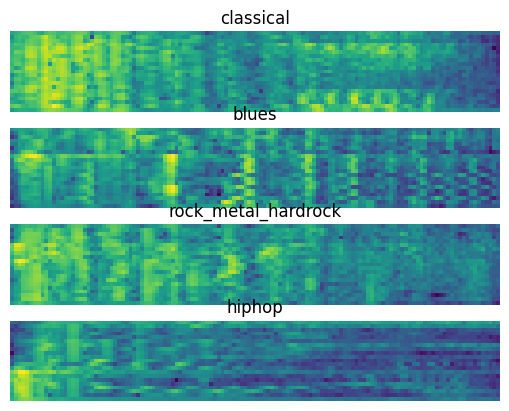

In [20]:

meltraindata = np.load('/content/drive/MyDrive/Machine_Learning/music_genre_data_di/train/melgrams/X.npy')
meltrainlabels = np.load('/content/drive/MyDrive/Machine_Learning/music_genre_data_di/train/melgrams/labels.npy')

meltestdata = np.load('/content/drive/MyDrive/Machine_Learning/music_genre_data_di/test/melgrams/X.npy')
meltestlabels = np.load('/content/drive/MyDrive/Machine_Learning/music_genre_data_di/test/melgrams/labels.npy')

melvaldata = np.load('/content/drive/MyDrive/Machine_Learning/music_genre_data_di/val/melgrams/X.npy')
melvallabels = np.load('/content/drive/MyDrive/Machine_Learning/music_genre_data_di/val/melgrams/labels.npy')


training_data = dataset(meltraindata, meltrainlabels, labels_map, torch.tensor)
val_data = dataset(melvaldata, melvallabels, labels_map, torch.tensor)
test_data = dataset(meltestdata, meltestlabels, labels_map, torch.tensor)

train_dataloader = DataLoader(training_data, batch_size=16,shuffle=True )
val_dataloader =  DataLoader(val_data, batch_size=16,shuffle=True )
test_dataloader =  DataLoader(test_data, batch_size=16,shuffle=False)


X, Y = training_data[range(0,len(training_data))]
Y = torch.tensor(Y)
indices_by_label = {label.item(): (Y == label).nonzero(as_tuple=True)[0].tolist() for label in torch.unique(Y)}
# Select a random index for each label
selected_indices = {label: random.choice(indices) for label, indices in indices_by_label.items()}
# Retrieve the corresponding x values
selected_x = {label: X[idx] for label, idx in selected_indices.items()}

opp_map = {
    0:"classical",
    1:"blues",
    2:"rock_metal_hardrock",
    3:"hiphop",
}

for i,key in enumerate(selected_x.keys()):
  img = selected_x[key]
  plt.subplot(4,1,i+1)
  plt.title(opp_map[key])
  plt.axis("off")
  plt.imshow(img.squeeze())


## Step 2 Convolutional Network

In [22]:
device = 'cpu'

class LeNet(nn.Module):
  def __init__(self, padding=0, pooling=None, activation_function=None):
      super(LeNet, self).__init__()
      channels, height, width = (1,21, 128) #Mel Spectrograms input dimensions
      self.activation_function = activation_function
      self.pooling = pooling
      self._conv_shape = None

      self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=padding)
      self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=padding)
      self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=padding)
      self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=padding)

      self._conv_layer_output_shape((channels, height, width)) # Calculate Convolutional Layer output

      self.linear1 = nn.Linear(self._conv_shape, 1024)
      self.linear2 = nn.Linear(1024, 256)
      self.linear3 = nn.Linear(256,32)
      self.linear4 = nn.Linear(32,4)



  def _conv_layer_output_shape(self, shape):
    x = torch.rand(1, *shape) # dummy
    x = self._convolutional_layers(x)
    self._conv_shape = x.numel()

  def _convolutional_layers(self,x):
    x = self.conv1(x)
    if self.activation_function:
      x = self.activation_function(x)
    if self.pooling:
      x = self.pooling(x)

    x = self.conv2(x)
    if self.activation_function:
      x = self.activation_function(x)
    if self.pooling:
      x = self.pooling(x)

    x = self.conv3(x)
    if self.activation_function:
      x = self.activation_function(x)
    if self.pooling:
      x = self.pooling(x)

    x = self.conv4(x)
    if self.activation_function:
      x = self.activation_function(x)
    if self.pooling:
      x = self.pooling(x)
    return x

  def _linear_layers(self,x):
    x = self.linear1(x)
    if self.activation_function:
      x = self.activation_function(x)
    x = self.linear2(x)
    if self.activation_function:
      x = self.activation_function(x)
    x = self.linear3(x)
    if self.activation_function:
      x = self.activation_function(x)
    x = self.linear4(x)
    return x



  def forward(self, x):
    x = self._convolutional_layers(x)
    x = torch.flatten(x,1)
    x = self._linear_layers(x)
    return x


model = LeNet().to(device)
print(model)

LeNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=71680, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=4, bias=True)
)


## Step 3 Training and Evaluation of our Model

In [23]:
def trainCNN(num_epochs, optimizer, dataloader,cost_func,model, device):
  model.to(device)
  model.train()
  size = len(dataloader.dataset)
  for epoch in range(num_epochs):
    print(f"current epoch: {epoch}\n")
    for batch, (X,y) in enumerate(dataloader):
      X = X.to(device)
      y = y.to(device)
      X = torch.unsqueeze(X,1)
      pred = model(X.float())
      loss = cost_func(pred,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
  return model

def evaluateCNN(dataloader, cost_func, model, device):
    model.to(device)
    model.eval()

    test_loss = 0.0
    test_f1 = 0.0
    test_acc = 0.0
    correct = 0
    size = len(dataloader.dataset)
    accuracy = Accuracy(task="multiclass", num_classes=4).to(device)
    f1 = F1Score(task="multiclass", num_classes=4, average="macro").to(device)
    confmatrix = ConfusionMatrix(task="multiclass", num_classes=4).to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device).float()
            y = y.to(device)
            X = torch.unsqueeze(X,1)
            pred = model(X)
            all_preds.append(pred)
            all_labels.append(y)

            test_loss += cost_func(pred, y).item() * X.size(0)
            test_acc += accuracy(pred, y).item() * X.size(0)
            test_f1 += f1(pred, y).item() * X.size(0)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    test_acc /= size
    test_f1 /= size

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    confusion_matrix = confmatrix(all_preds.argmax(dim=1), all_labels)

    print(f"Avg Accuracy: {100*test_acc:>8f}%, Avg loss: {test_loss:>8f}")
    print(f"F1 score is: {test_f1}")
    print("Confusion Matrix:")
    print(confusion_matrix.cpu().numpy())

    return test_loss, test_f1, test_acc, confusion_matrix

def train_and_evaluateCNN(num_epochs, optimizer,train_dataloader,valid_dataloader,cost_func,model,device):
  bestmodel = None
  bestf1 = -1
  bestepoch = -1
  size = len(train_dataloader.dataset)
  model.to(device)
  for epoch in range(num_epochs):
    print(f"current epoch: {epoch}\n")
    for batch, (X,y) in enumerate(train_dataloader):
      X = X.to(device)
      y = y.to(device)
      X = torch.unsqueeze(X,1)
      pred = model(X.float())
      loss = cost_func(pred,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss, current = loss.item(), batch * len(X)
      #Disable printing for this step, to save time
      #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    tl,f1, acc, conf = evaluateCNN(valid_dataloader, cost_func, model,device)
    if f1 > bestf1:
      bestmodel = model
      bestf1 = f1
      bestepoch = epoch

  print(f"best epoch is: {bestepoch}")
  return bestmodel


device = "cpu"

dev_names = {
    "cpu" : "CPU",
    "cuda" : "GPU"
}



model = LeNet().to(device)
cost_func = nn.CrossEntropyLoss()
learning_rate = 0.0001  # Start with a lower learning rate
#when using learning rate 0.002 we encountered the exploding gradients problem...
num_epochs = 30
batch_size = 16
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
for dev, name in dev_names.items():
  start_time = time.time()
  model = train_and_evaluateCNN(num_epochs, optimizer, train_dataloader,val_dataloader, cost_func, model,dev)
  print(f"\nTotal Time for Training in {name}: {time.time() - start_time}")
  evaluateCNN(test_dataloader, cost_func, model,dev)

current epoch: 0

Avg Accuracy: 47.750000%, Avg loss: 1.253927
F1 score is: 0.38573354110121727
Confusion Matrix:
[[145   0  22  33]
 [ 55   0  65  80]
 [ 15   0  82 103]
 [ 12   0  33 155]]
current epoch: 1

Avg Accuracy: 45.250000%, Avg loss: 1.147988
F1 score is: 0.3766078811883926
Confusion Matrix:
[[148  48   0   4]
 [ 52 128   2  18]
 [ 12 139   6  43]
 [ 16 103   1  80]]
current epoch: 2

Avg Accuracy: 40.500000%, Avg loss: 1.195562
F1 score is: 0.33615219861268997
Confusion Matrix:
[[ 72 119   1   8]
 [ 10 176   4  10]
 [  1 166  22  11]
 [  1 142   3  54]]
current epoch: 3

Avg Accuracy: 53.250000%, Avg loss: 1.106028
F1 score is: 0.4479525700211525
Confusion Matrix:
[[172  15  12   1]
 [ 70  59  64   7]
 [ 21  20 157   2]
 [ 33  17 112  38]]
current epoch: 4

Avg Accuracy: 51.375000%, Avg loss: 1.060820
F1 score is: 0.44291103422641753
Confusion Matrix:
[[127  58   1  14]
 [ 30 136   3  31]
 [  3 115  13  69]
 [  7  57   1 135]]
current epoch: 5

Avg Accuracy: 58.000000%, Avg

Total Time for Training in CPU: 4293.326610088348
Avg Accuracy: 56.758721%, Avg loss: 1.080199
F1 score is: 0.2610119650963434
Total Time for Training in GPU: 120.61348843574524
Avg Accuracy: 55.087209%, Avg loss: 1.196429
F1 score is: 0.236123317679347

Overall the training results are very bad. This can be explained by the absence of pooling and padding.
Without pooling, the feature maps retain redundant information, which makes learning less efficient and slower. This is especially visible in the 
disparity between CPU and GPU time(in contrast to part 1, CPU time sky rockets due to computational complexity redundant features).
Without padding, we run the risk of losing important edge-related features, as the convolution operation near the edges of the image has fewer neighboring pixels to process.
This explains the especially low F1 score we got. Adding both pooling and padding to our model greatly improves performance as seen below.




## Step 4 Pooling and Padding

In [24]:
device = "cpu"
model = LeNet(padding=2, pooling=nn.MaxPool2d(kernel_size=2)).to(device)
cost_func = nn.CrossEntropyLoss()
learning_rate = 0.0001  # Start with a lower learning rate
#when using learning rate 0.002 we encountered the exploding gradients problem...
num_epochs = 30
batch_size = 16
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
start_time = time.time()
model = train_and_evaluateCNN(num_epochs, optimizer, train_dataloader,val_dataloader,cost_func, model,device)
print(f"\nTotal Time for Training in CPU with pooling and padding: {time.time() - start_time}")
evaluateCNN(test_dataloader, cost_func, model,device)

current epoch: 0

Avg Accuracy: 25.250000%, Avg loss: 1.373792
F1 score is: 0.12182024221867323
Confusion Matrix:
[[  4   0   0 196]
 [  7  11   0 182]
 [  3  18   0 179]
 [ 10   3   0 187]]
current epoch: 1

Avg Accuracy: 30.500000%, Avg loss: 1.367544
F1 score is: 0.19627639040350914
Confusion Matrix:
[[ 72   0   0 128]
 [ 24   0   0 176]
 [ 13   2   0 185]
 [ 28   0   0 172]]
current epoch: 2

Avg Accuracy: 27.500000%, Avg loss: 1.360741
F1 score is: 0.14218721825629474
Confusion Matrix:
[[ 22   0   0 178]
 [  9   0   0 191]
 [  0   0   0 200]
 [  2   0   0 198]]
current epoch: 3

Avg Accuracy: 40.125000%, Avg loss: 1.355033
F1 score is: 0.2772618062794209
Confusion Matrix:
[[132   0   0  68]
 [ 34   1   0 165]
 [  9   0   0 191]
 [ 12   0   0 188]]
current epoch: 4

Avg Accuracy: 37.875000%, Avg loss: 1.348113
F1 score is: 0.2590839923918247
Confusion Matrix:
[[104   0   0  96]
 [ 20   0   0 180]
 [  4   0   0 196]
 [  1   0   0 199]]
current epoch: 5

Avg Accuracy: 37.750000%, Avg

(1.0433437999251276,
 0.3274279066989588,
 0.498546511627907,
 tensor([[257,  10,   5,  25],
         [ 38,  49,  45, 192],
         [ 36,  33,  47, 283],
         [ 11,   6,   6, 333]]))

Total Time for Training in CPU with pooling and padding: 257.3441216945648
Avg Accuracy: 49.854651%, Avg loss: 1.043344
F1 score is: 0.3274279066989588

As expected pooling and padding greatly reduce training times and increase F1 score as many featurs are dropped due to pooling and at the same time important information is preserved with the help of padding.

##Step 5 Using the ReLU Activation Function

In [25]:
device = "cpu"
model = LeNet(padding=2, pooling=nn.MaxPool2d(kernel_size=2), activation_function=nn.ReLU()).to(device)
cost_func = nn.CrossEntropyLoss()
learning_rate = 0.0001  # Start with a lower learning rate
#when using learning rate 0.002 we encountered the exploding gradients problem...
num_epochs = 30
batch_size = 16
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
model = train_and_evaluateCNN(num_epochs, optimizer, train_dataloader,val_dataloader,cost_func, model,device)
evaluateCNN(test_dataloader, cost_func, model,device)

current epoch: 0

Avg Accuracy: 25.250000%, Avg loss: 1.380531
F1 score is: 0.1032032086700201
Confusion Matrix:
[[  0   2 195   3]
 [  0   0 200   0]
 [  0   0 199   1]
 [  0   1 196   3]]
current epoch: 1

Avg Accuracy: 43.250000%, Avg loss: 1.377421
F1 score is: 0.2850545761734247
Confusion Matrix:
[[  0   4  88 108]
 [  0   1 123  76]
 [  0   0 176  24]
 [  0   0  31 169]]
current epoch: 2

Avg Accuracy: 36.875000%, Avg loss: 1.375229
F1 score is: 0.2543098609149456
Confusion Matrix:
[[  0   2  18 180]
 [  0   2  22 176]
 [  0   0  94 106]
 [  0   0   1 199]]
current epoch: 3

Avg Accuracy: 28.625000%, Avg loss: 1.373528
F1 score is: 0.15270504932850598
Confusion Matrix:
[[  0   0   2 198]
 [  0   0   1 199]
 [  0   0  29 171]
 [  0   0   0 200]]
current epoch: 4

Avg Accuracy: 25.875000%, Avg loss: 1.372214
F1 score is: 0.11313771177083254
Confusion Matrix:
[[  0   0   0 200]
 [  0   0   0 200]
 [  0   0   7 193]
 [  0   0   0 200]]
current epoch: 5

Avg Accuracy: 25.250000%, Avg 

(1.3469085804251737,
 0.3238936476842609,
 0.38808139534883723,
 tensor([[184,   0,   0, 113],
         [ 44,   0,   0, 280],
         [ 35,   0,   0, 364],
         [  6,   0,   0, 350]]))

Avg Accuracy: 38.808140%, Avg loss: 1.346909
F1 score is: 0.3238936476842609

The introduction of the ReLU activation function seems to affect the performance of our score negatively, which is something 
not expected. We attribute this unexpected behavior to the reduce learning rate we introduced above, as a compromise in order to 
avoid the exploding gradients problem we encountered during some runs.
Normally, we would expect improved training performance, as ctivation functions contribute to a network's ability to generalize from the training data to unseen data.

# Part 3 Improving Performance

## Reproducibility

In [26]:
meltraindata = np.load('/content/drive/MyDrive/Machine_Learning/music_genre_data_di/train/melgrams/X.npy')
meltrainlabels = np.load('/content/drive/MyDrive/Machine_Learning/music_genre_data_di/train/melgrams/labels.npy')

meltestdata = np.load('/content/drive/MyDrive/Machine_Learning/music_genre_data_di/test/melgrams/X.npy')
meltestlabels = np.load('/content/drive/MyDrive/Machine_Learning/music_genre_data_di/test/melgrams/labels.npy')

melvaldata = np.load('/content/drive/MyDrive/Machine_Learning/music_genre_data_di/val/melgrams/X.npy')
melvallabels = np.load('/content/drive/MyDrive/Machine_Learning/music_genre_data_di/val/melgrams/labels.npy')


training_data = dataset(meltraindata, meltrainlabels, labels_map, torch.tensor)
val_data = dataset(melvaldata, melvallabels, labels_map, torch.tensor)
test_data = dataset(meltestdata, meltestlabels, labels_map, torch.tensor)

seed = 42 #the answer to life the universe and everything

#Setting a seed method for dataloaders
g_cpu = torch.Generator(device='cpu')
train_dataloader = DataLoader(training_data, batch_size=16,shuffle=True, generator=g_cpu)
val_dataloader = DataLoader(val_data, batch_size=16,shuffle=True,generator=g_cpu)
# No need to seed the test loader
test_dataloader = DataLoader(test_data, batch_size=16,shuffle=False)



def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


#Define the set_epoch function
def set_epoch(self, epoch):
    self.epoch = epoch
    if self.shuffle:
        self.generator.manual_seed(2147483647 + self.epoch)

#Bind the set_epoch function to the DataLoader instances
train_dataloader.shuffle = True
train_dataloader.set_epoch = types.MethodType(set_epoch, train_dataloader)
val_dataloader.shuffle = True
val_dataloader.set_epoch = types.MethodType(set_epoch, val_dataloader)



#Ensure that the results are reproducible when using GPU operations with cuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [27]:
def trainCNN_reproductible(num_epochs, optimizer, dataloader,cost_func,model,device):
  model.to(device)
  model.train()
  size = len(dataloader.dataset)
  for epoch in range(num_epochs):
    epoch_loss = 0
    print(f"current epoch: {epoch}\n")
    dataloader.set_epoch(epoch)
    for batch, (X,y) in enumerate(dataloader):
      X = X.to(device)
      y = y.to(device)
      X = torch.unsqueeze(X,1)
      pred = model(X.float())
      loss = cost_func(pred,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
    print(f"Sum of batch losses for epoch {epoch}: {epoch_loss}")
  return model


#Initialize the model with a manual seed
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cost_func = nn.CrossEntropyLoss()
learning_rate = 0.0001
num_epochs = 5
batch_size = 16

model = LeNet(padding=2, pooling=nn.MaxPool2d(kernel_size=2), activation_function=nn.ReLU()).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
model = trainCNN_reproductible(num_epochs, optimizer, train_dataloader, cost_func, model,device)
evaluateCNN(test_dataloader,cost_func,model,device)

model = LeNet(padding=2, pooling=nn.MaxPool2d(kernel_size=2), activation_function=nn.ReLU()).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
model = trainCNN_reproductible(num_epochs, optimizer, train_dataloader, cost_func, model, device)
evaluateCNN(test_dataloader,cost_func,model,device)

current epoch: 0

Sum of batch losses for epoch 0: 277.09355652332306
current epoch: 1

Sum of batch losses for epoch 1: 276.35214626789093
current epoch: 2

Sum of batch losses for epoch 2: 275.6562249660492
current epoch: 3

Sum of batch losses for epoch 3: 274.98939776420593
current epoch: 4

Sum of batch losses for epoch 4: 274.4251626729965
Avg Accuracy: 37.281977%, Avg loss: 1.373262
F1 score is: 0.31670496383205404
Confusion Matrix:
[[163   0   0 134]
 [ 33   0   0 291]
 [ 10   0   0 389]
 [  6   0   0 350]]
current epoch: 0

Sum of batch losses for epoch 0: 277.2186493873596
current epoch: 1

Sum of batch losses for epoch 1: 277.0618590116501
current epoch: 2

Sum of batch losses for epoch 2: 276.92426788806915
current epoch: 3

Sum of batch losses for epoch 3: 276.8097348213196
current epoch: 4

Sum of batch losses for epoch 4: 276.7086510658264
Avg Accuracy: 21.947674%, Avg loss: 1.388278
F1 score is: 0.1959238675704529
Confusion Matrix:
[[292   0   0   5]
 [324   0   0   0]


(1.3882781655289407,
 0.1959238675704529,
 0.2194767441860465,
 tensor([[292,   0,   0,   5],
         [324,   0,   0,   0],
         [399,   0,   0,   0],
         [346,   0,   0,  10]], device='cuda:0'))

We didn't manage to achieve reproductibility despite introducing custom seeds for all the libraries we used.
Maybe there are other parameters we didn't take into account...


## Using Different Optimizers


In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def train_and_evaluateCNN(num_epochs, optimizer,train_dataloader,valid_dataloader,cost_func,model,device):
  bestmodel = None
  bestf1 = -1
  bestepoch = -1
  size = len(train_dataloader.dataset)
  model.to(device)
  epoch_progress = tqdm(range(num_epochs), desc="Epochs")
  for epoch in epoch_progress:
    #print(f"current epoch: {epoch}\n")
    for batch, (X,y) in enumerate(train_dataloader):
      X = X.to(device)
      y = y.to(device)
      X = torch.unsqueeze(X,1)
      pred = model(X.float())
      loss = cost_func(pred,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      #Disable printing for this step, to save time
      #loss, current = loss.item(), batch * len(X)
      #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    tl,f1, acc, conf = evaluateCNN(valid_dataloader, cost_func, model,device)
    if f1 > bestf1:
      bestmodel = model
      bestf1 = f1
      bestepoch = epoch
    # Update the tqdm progress bar with the current loss and metrics
    epoch_progress.set_postfix({
        "loss": loss.item(),
        "f1": f1,
        "accuracy": acc,
        "best_f1": bestf1,
        "best_epoch": bestepoch
    })

  print(f"best epoch is: {bestepoch}")
  return bestmodel


def evaluateCNN(dataloader, cost_func, model, device):
    model.to(device)
    model.eval()

    test_loss = 0.0
    test_f1 = 0.0
    test_acc = 0.0
    correct = 0
    size = len(dataloader.dataset)
    accuracy = Accuracy(task="multiclass", num_classes=4).to(device)
    f1 = F1Score(task="multiclass", num_classes=4, average="macro").to(device)
    confmatrix = ConfusionMatrix(task="multiclass", num_classes=4).to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device).float()
            y = y.to(device)
            X = torch.unsqueeze(X,1)
            pred = model(X)
            all_preds.append(pred)
            all_labels.append(y)

            test_loss += cost_func(pred, y).item() * X.size(0)
            test_acc += accuracy(pred, y).item() * X.size(0)
            test_f1 += f1(pred, y).item() * X.size(0)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    test_acc /= size
    test_f1 /= size

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    confusion_matrix = confmatrix(all_preds.argmax(dim=1), all_labels)

    # print(f"Avg Accuracy: {100*test_acc:>8f}%, Avg loss: {test_loss:>8f}")
    # print(f"F1 score is: {test_f1}")
    # print("Confusion Matrix:")
    # print(confusion_matrix.cpu().numpy())

    return test_loss, test_f1, test_acc, confusion_matrix




model = LeNet(padding=2, pooling=nn.MaxPool2d(kernel_size=2), activation_function=nn.ReLU()).to(device)

# Save the initial state, we will use it later
initial_state = model.state_dict()
torch.save(initial_state, 'initial_state.pth')


learning_rate = 0.0001  # Start with a lower learning rate
cost_func = nn.CrossEntropyLoss()
num_epochs = 30
batch_size = 16


# Define the optimizers to test
optimizers = {
  "Adadelta": torch.optim.Adadelta(model.parameters(), lr=learning_rate),
  "Adagrad" : torch.optim.Adagrad(model.parameters(),lr=learning_rate),
  "Adam": torch.optim.Adam(model.parameters(),lr=learning_rate),
  "AdamW": torch.optim.AdamW(model.parameters(),lr=learning_rate),
  "Adamax": torch.optim.Adamax(model.parameters(),lr=learning_rate),
  "ASGD": torch.optim.Adamax(model.parameters(),lr=learning_rate),
  "NAdam": torch.optim.NAdam(model.parameters(),lr=learning_rate),
  "RAdam": torch.optim.RAdam(model.parameters(),lr=learning_rate),
  "RMSprop": torch.optim.RMSprop(model.parameters(),lr=learning_rate),
  "RMSprop": torch.optim.RMSprop(model.parameters(),lr=learning_rate),
  "Rprop": torch.optim.Rprop(model.parameters(), lr = learning_rate),
  "SGD": torch.optim.SGD(model.parameters(), lr=learning_rate)
}

# Dictionary to store results
results = {
  "Optimizer": [],
  "F1 Score": [],
  "Accuracy": []
}

cost_func = nn.CrossEntropyLoss()
for optimizer_name, optimizer in optimizers.items():
  print(f"Training with {optimizer_name}...")
  model = train_and_evaluateCNN(num_epochs, optimizer, train_dataloader,val_dataloader,cost_func, model,device)
  test_loss, test_f1, test_acc, confmatrix = evaluateCNN(test_dataloader,cost_func,model,device)
  results["Optimizer"].append(optimizer_name)
  results["F1 Score"].append(test_f1)
  results["Accuracy"].append(test_acc)

  # Restore the initial state
  initial_state = torch.load('initial_state.pth')
  model.load_state_dict(initial_state)

import pandas as pd
print("\n\n\n")
df = pd.DataFrame(results)
print(df)

Training with Adadelta...


Epochs: 100%|██████████| 30/30 [00:51<00:00,  1.73s/it, loss=1.37, f1=0.384, accuracy=0.484, best_f1=0.398, best_epoch=28]


best epoch is: 28
Training with Adagrad...


Epochs: 100%|██████████| 30/30 [00:49<00:00,  1.64s/it, loss=1.12, f1=0.578, accuracy=0.62, best_f1=0.578, best_epoch=29]


best epoch is: 29
Training with Adam...


Epochs: 100%|██████████| 30/30 [00:50<00:00,  1.67s/it, loss=0.00071, f1=0.739, accuracy=0.764, best_f1=0.742, best_epoch=25]


best epoch is: 25
Training with AdamW...


Epochs: 100%|██████████| 30/30 [00:50<00:00,  1.69s/it, loss=0.000697, f1=0.737, accuracy=0.765, best_f1=0.748, best_epoch=10]


best epoch is: 10
Training with Adamax...


Epochs: 100%|██████████| 30/30 [00:50<00:00,  1.68s/it, loss=0.619, f1=0.739, accuracy=0.76, best_f1=0.739, best_epoch=29]


best epoch is: 29
Training with ASGD...


Epochs: 100%|██████████| 30/30 [00:50<00:00,  1.69s/it, loss=0.865, f1=0.734, accuracy=0.756, best_f1=0.737, best_epoch=27]


best epoch is: 27
Training with NAdam...


Epochs: 100%|██████████| 30/30 [00:51<00:00,  1.72s/it, loss=0.000124, f1=0.751, accuracy=0.78, best_f1=0.759, best_epoch=24]


best epoch is: 24
Training with RAdam...


Epochs: 100%|██████████| 30/30 [00:51<00:00,  1.72s/it, loss=0.361, f1=0.632, accuracy=0.68, best_f1=0.752, best_epoch=28]


best epoch is: 28
Training with RMSprop...


Epochs: 100%|██████████| 30/30 [00:50<00:00,  1.68s/it, loss=0.00104, f1=0.709, accuracy=0.745, best_f1=0.735, best_epoch=14]


best epoch is: 14
Training with Rprop...


Epochs: 100%|██████████| 30/30 [00:53<00:00,  1.80s/it, loss=1.19, f1=0.596, accuracy=0.624, best_f1=0.61, best_epoch=26]


best epoch is: 26
Training with SGD...


Epochs: 100%|██████████| 30/30 [00:48<00:00,  1.60s/it, loss=1.28, f1=0.285, accuracy=0.42, best_f1=0.316, best_epoch=14]


best epoch is: 14




   Optimizer  F1 Score  Accuracy
0   Adadelta  0.279180  0.449855
1    Adagrad  0.310233  0.563227
2       Adam  0.370985  0.724564
3      AdamW  0.370639  0.741279
4     Adamax  0.429098  0.742733
5       ASGD  0.437783  0.747820
6      NAdam  0.402230  0.742006
7      RAdam  0.373598  0.676599
8    RMSprop  0.381771  0.740552
9      Rprop  0.263940  0.576308
10       SGD  0.317775  0.402616


We observe big differences in both F1 score and accuracy by using different optimizers. We conclude that choosing the correct optimizer is extremely important for the performance of our model.

## Batch Normalization and Regularization

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


class LeNet(nn.Module):
  def __init__(self,per=0, padding=0, pooling=None, activation_function=None):
      super(LeNet, self).__init__()
      channels, height, width = (1,21, 128) #Mel Spectrograms input dimensions
      self.activation_function = activation_function
      self.pooling = pooling
      self._conv_shape = None

      self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=padding)
      self.bn1 = nn.BatchNorm2d(16)
      self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=padding)
      self.bn2 = nn.BatchNorm2d(32)
      self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=padding)
      self.bn3 = nn.BatchNorm2d(64)
      self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=padding)
      self.bn4 = nn.BatchNorm2d(128)

      self._conv_layer_output_shape((channels, height, width)) # Calculate Convolutional Layer output

      self.linear1 = nn.Linear(self._conv_shape, 1024)
      self.linear2 = nn.Linear(1024, 256)
      self.linear3 = nn.Linear(256,32)
      self.linear4 = nn.Linear(32,4)
      self.dropout = nn.Dropout(p=per)


  def _conv_layer_output_shape(self, shape):
    x = torch.rand(1, *shape) # dummy
    x = self._convolutional_layers(x)
    self._conv_shape = x.numel()

  def _convolutional_layers(self,x):
    x = self.conv1(x)
    x = self.bn1(x)
    if self.activation_function:
        x = self.activation_function(x)
    if self.pooling:
        x = self.pooling(x)

    x = self.conv2(x)
    x = self.bn2(x)
    if self.activation_function:
        x = self.activation_function(x)
    if self.pooling:
        x = self.pooling(x)

    x = self.conv3(x)
    x = self.bn3(x)
    if self.activation_function:
        x = self.activation_function(x)
    if self.pooling:
        x = self.pooling(x)

    x = self.conv4(x)
    x = self.bn4(x)
    if self.activation_function:
        x = self.activation_function(x)
    if self.pooling:
        x = self.pooling(x)
    return x

  def _linear_layers(self,x):
    x = self.linear1(x)
    if self.activation_function:
      x = self.activation_function(x)
    x = self.dropout(x)
    x = self.linear2(x)
    if self.activation_function:
      x = self.activation_function(x)
    x = self.dropout(x)
    x = self.linear3(x)
    if self.activation_function:
      x = self.activation_function(x)
    x = self.dropout(x)
    x = self.linear4(x)
    x = self.dropout(x)
    return x

  def forward(self, x):
    x = self._convolutional_layers(x)
    x = torch.flatten(x,1)
    x = self._linear_layers(x)
    return x


model = LeNet().to(device)
print(model)


LeNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=71680, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=4, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)


In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cost_func = nn.CrossEntropyLoss()
for num_epochs in [30,60]:
  print(f"epochs: {num_epochs}")
  for (per,wd) in [(0.0,1e-8),(0.0,1e-5),(0.0,1e-3),(0.1,1e-8), (0.1,1e-5), (0.1,1e-3), (0.2,1e-8), (0.2,1e-5), (0.2,1e-3), (0.3,1e-8),(0.3,1e-5), (0.3,1e-3),(0.4,1e-8), (0.4,1e-5), (0.4,1e-3), (0.1,0.0), (0.2,0.0), (0.3,0.0)]:
    model = LeNet(per=per,padding=2, pooling=nn.MaxPool2d(kernel_size=2), activation_function=nn.ReLU()).to(device)
    optimizer = torch.optim.ASGD(model.parameters(), lr = learning_rate, weight_decay= wd)
    model = train_and_evaluateCNN(num_epochs, optimizer, train_dataloader,val_dataloader,cost_func,model, device)
    test_loss, f1_t, acc_t, confmatrix = evaluateCNN(test_dataloader, cost_func, model,device)
    test_loss, f1_v, acc_v, confmatrix = evaluateCNN(val_dataloader, cost_func, model,device)
    print(f"For weight decay = {wd} and dropout = {per} we got:Accuracy for test: {acc_t}, f1_score for test: {f1_t}, Accuracy for val: {acc_v}, f1_score for val: {f1_v}")

epochs: 30


Epochs: 100%|██████████| 30/30 [01:00<00:00,  2.03s/it, loss=0.721, f1=0.613, accuracy=0.667, best_f1=0.614, best_epoch=28]


best epoch is: 28
For weight decay = 1e-08 and dropout = 0.0 we got:Accuracy for test: 0.6693313953488372, f1_score for test: 0.39178195963938567, Accuracy for val: 0.6675, f1_score for val: 0.6183820700645447


Epochs: 100%|██████████| 30/30 [00:59<00:00,  2.00s/it, loss=1.08, f1=0.596, accuracy=0.623, best_f1=0.596, best_epoch=29]


best epoch is: 29
For weight decay = 1e-05 and dropout = 0.0 we got:Accuracy for test: 0.6366279069767442, f1_score for test: 0.32259735575508935, Accuracy for val: 0.6225, f1_score for val: 0.5976405817270279


Epochs: 100%|██████████| 30/30 [01:00<00:00,  2.02s/it, loss=1.07, f1=0.528, accuracy=0.585, best_f1=0.55, best_epoch=28]


best epoch is: 28
For weight decay = 0.001 and dropout = 0.0 we got:Accuracy for test: 0.6053779069767442, f1_score for test: 0.2645465076446187, Accuracy for val: 0.585, f1_score for val: 0.5406985175609589


Epochs: 100%|██████████| 30/30 [01:00<00:00,  2.02s/it, loss=0.716, f1=0.621, accuracy=0.671, best_f1=0.621, best_epoch=29]


best epoch is: 29
For weight decay = 1e-08 and dropout = 0.1 we got:Accuracy for test: 0.6613372093023255, f1_score for test: 0.37024985223488754, Accuracy for val: 0.67125, f1_score for val: 0.6277568119764328


Epochs: 100%|██████████| 30/30 [01:00<00:00,  2.03s/it, loss=0.797, f1=0.646, accuracy=0.698, best_f1=0.646, best_epoch=29]


best epoch is: 29
For weight decay = 1e-05 and dropout = 0.1 we got:Accuracy for test: 0.6729651162790697, f1_score for test: 0.36567638554545334, Accuracy for val: 0.6975, f1_score for val: 0.6474262821674347


Epochs: 100%|██████████| 30/30 [01:00<00:00,  2.03s/it, loss=1.08, f1=0.541, accuracy=0.581, best_f1=0.545, best_epoch=28]


best epoch is: 28
For weight decay = 0.001 and dropout = 0.1 we got:Accuracy for test: 0.6010174418604651, f1_score for test: 0.28639277493104687, Accuracy for val: 0.58125, f1_score for val: 0.5492351526021957


Epochs: 100%|██████████| 30/30 [01:00<00:00,  2.02s/it, loss=0.741, f1=0.601, accuracy=0.646, best_f1=0.601, best_epoch=29]


best epoch is: 29
For weight decay = 1e-08 and dropout = 0.2 we got:Accuracy for test: 0.6526162790697675, f1_score for test: 0.3567135846025722, Accuracy for val: 0.64625, f1_score for val: 0.6114558529853821


Epochs: 100%|██████████| 30/30 [01:01<00:00,  2.03s/it, loss=0.959, f1=0.608, accuracy=0.631, best_f1=0.608, best_epoch=29]


best epoch is: 29
For weight decay = 1e-05 and dropout = 0.2 we got:Accuracy for test: 0.6329941860465116, f1_score for test: 0.3315702095454515, Accuracy for val: 0.63125, f1_score for val: 0.5752386248111725


Epochs: 100%|██████████| 30/30 [01:00<00:00,  2.02s/it, loss=0.849, f1=0.581, accuracy=0.639, best_f1=0.591, best_epoch=27]


best epoch is: 27
For weight decay = 0.001 and dropout = 0.2 we got:Accuracy for test: 0.627906976744186, f1_score for test: 0.3134835013513302, Accuracy for val: 0.63875, f1_score for val: 0.5852128410339356


Epochs: 100%|██████████| 30/30 [01:00<00:00,  2.03s/it, loss=0.72, f1=0.549, accuracy=0.614, best_f1=0.573, best_epoch=28]


best epoch is: 28
For weight decay = 1e-08 and dropout = 0.3 we got:Accuracy for test: 0.625, f1_score for test: 0.31121536976722786, Accuracy for val: 0.61375, f1_score for val: 0.5777793949842454


Epochs: 100%|██████████| 30/30 [01:00<00:00,  2.03s/it, loss=0.907, f1=0.512, accuracy=0.573, best_f1=0.558, best_epoch=27]


best epoch is: 27
For weight decay = 1e-05 and dropout = 0.3 we got:Accuracy for test: 0.6206395348837209, f1_score for test: 0.2960311759826402, Accuracy for val: 0.5725, f1_score for val: 0.5212267524003983


Epochs: 100%|██████████| 30/30 [01:00<00:00,  2.02s/it, loss=0.739, f1=0.53, accuracy=0.584, best_f1=0.53, best_epoch=29]


best epoch is: 29
For weight decay = 0.001 and dropout = 0.3 we got:Accuracy for test: 0.6090116279069767, f1_score for test: 0.28805788729859644, Accuracy for val: 0.58375, f1_score for val: 0.5329331606626511


Epochs: 100%|██████████| 30/30 [01:00<00:00,  2.03s/it, loss=1.05, f1=0.654, accuracy=0.685, best_f1=0.654, best_epoch=29]


best epoch is: 29
For weight decay = 1e-08 and dropout = 0.4 we got:Accuracy for test: 0.6475290697674418, f1_score for test: 0.37337052659673053, Accuracy for val: 0.685, f1_score for val: 0.6358650410175324


Epochs: 100%|██████████| 30/30 [01:00<00:00,  2.02s/it, loss=0.871, f1=0.543, accuracy=0.599, best_f1=0.555, best_epoch=28]


best epoch is: 28
For weight decay = 1e-05 and dropout = 0.4 we got:Accuracy for test: 0.6293604651162791, f1_score for test: 0.2896480547090949, Accuracy for val: 0.59875, f1_score for val: 0.5490181016921997


Epochs: 100%|██████████| 30/30 [01:00<00:00,  2.03s/it, loss=0.739, f1=0.603, accuracy=0.634, best_f1=0.603, best_epoch=29]


best epoch is: 29
For weight decay = 0.001 and dropout = 0.4 we got:Accuracy for test: 0.6162790697674418, f1_score for test: 0.290662839922101, Accuracy for val: 0.63375, f1_score for val: 0.6060764318704606


Epochs: 100%|██████████| 30/30 [01:00<00:00,  2.00s/it, loss=1.06, f1=0.536, accuracy=0.593, best_f1=0.545, best_epoch=28]


best epoch is: 28
For weight decay = 0.0 and dropout = 0.1 we got:Accuracy for test: 0.5930232558139535, f1_score for test: 0.2697461252209059, Accuracy for val: 0.5925, f1_score for val: 0.5530495554208755


Epochs: 100%|██████████| 30/30 [01:00<00:00,  2.01s/it, loss=0.924, f1=0.564, accuracy=0.604, best_f1=0.574, best_epoch=28]


best epoch is: 28
For weight decay = 0.0 and dropout = 0.2 we got:Accuracy for test: 0.6177325581395349, f1_score for test: 0.3000917559229704, Accuracy for val: 0.60375, f1_score for val: 0.5684790730476379


Epochs: 100%|██████████| 30/30 [01:00<00:00,  2.02s/it, loss=0.951, f1=0.593, accuracy=0.652, best_f1=0.593, best_epoch=29]


best epoch is: 29
For weight decay = 0.0 and dropout = 0.3 we got:Accuracy for test: 0.6380813953488372, f1_score for test: 0.32397186175681825, Accuracy for val: 0.6525, f1_score for val: 0.5956343364715576
epochs: 60


Epochs: 100%|██████████| 60/60 [02:01<00:00,  2.02s/it, loss=0.691, f1=0.708, accuracy=0.741, best_f1=0.74, best_epoch=49]


best epoch is: 49
For weight decay = 1e-08 and dropout = 0.0 we got:Accuracy for test: 0.7049418604651163, f1_score for test: 0.4052187853687724, Accuracy for val: 0.74125, f1_score for val: 0.7153729444742203


Epochs: 100%|██████████| 60/60 [02:01<00:00,  2.02s/it, loss=0.725, f1=0.728, accuracy=0.761, best_f1=0.747, best_epoch=54]


best epoch is: 54
For weight decay = 1e-05 and dropout = 0.0 we got:Accuracy for test: 0.6954941860465116, f1_score for test: 0.3898842571259931, Accuracy for val: 0.76125, f1_score for val: 0.7269630038738251


Epochs: 100%|██████████| 60/60 [02:01<00:00,  2.03s/it, loss=0.402, f1=0.741, accuracy=0.771, best_f1=0.741, best_epoch=59]


best epoch is: 59
For weight decay = 0.001 and dropout = 0.0 we got:Accuracy for test: 0.7267441860465116, f1_score for test: 0.4078585099168988, Accuracy for val: 0.77125, f1_score for val: 0.7369599843025207


Epochs: 100%|██████████| 60/60 [02:01<00:00,  2.03s/it, loss=0.48, f1=0.733, accuracy=0.767, best_f1=0.752, best_epoch=57]


best epoch is: 57
For weight decay = 1e-08 and dropout = 0.1 we got:Accuracy for test: 0.7034883720930233, f1_score for test: 0.4009015319522384, Accuracy for val: 0.7675, f1_score for val: 0.7417752522230149


Epochs: 100%|██████████| 60/60 [02:01<00:00,  2.03s/it, loss=0.52, f1=0.726, accuracy=0.749, best_f1=0.726, best_epoch=59]


best epoch is: 59
For weight decay = 1e-05 and dropout = 0.1 we got:Accuracy for test: 0.7063953488372093, f1_score for test: 0.3950659596729417, Accuracy for val: 0.74875, f1_score for val: 0.7304193311929703


Epochs: 100%|██████████| 60/60 [02:00<00:00,  2.01s/it, loss=0.626, f1=0.7, accuracy=0.739, best_f1=0.703, best_epoch=49]


best epoch is: 49
For weight decay = 0.001 and dropout = 0.1 we got:Accuracy for test: 0.7027616279069767, f1_score for test: 0.42496346645490374, Accuracy for val: 0.73875, f1_score for val: 0.6990505504608154


Epochs: 100%|██████████| 60/60 [02:00<00:00,  2.01s/it, loss=0.811, f1=0.708, accuracy=0.741, best_f1=0.729, best_epoch=57]


best epoch is: 57
For weight decay = 1e-08 and dropout = 0.2 we got:Accuracy for test: 0.7165697674418605, f1_score for test: 0.40434726550741945, Accuracy for val: 0.74125, f1_score for val: 0.6991897594928741


Epochs: 100%|██████████| 60/60 [02:00<00:00,  2.01s/it, loss=0.343, f1=0.698, accuracy=0.751, best_f1=0.752, best_epoch=56]


best epoch is: 56
For weight decay = 1e-05 and dropout = 0.2 we got:Accuracy for test: 0.7194767441860465, f1_score for test: 0.41977493971759494, Accuracy for val: 0.75125, f1_score for val: 0.7122550356388092


Epochs: 100%|██████████| 60/60 [02:01<00:00,  2.02s/it, loss=0.606, f1=0.732, accuracy=0.762, best_f1=0.747, best_epoch=52]


best epoch is: 52
For weight decay = 0.001 and dropout = 0.2 we got:Accuracy for test: 0.7325581395348837, f1_score for test: 0.40692081185447615, Accuracy for val: 0.7625, f1_score for val: 0.7211674565076828


Epochs: 100%|██████████| 60/60 [02:00<00:00,  2.02s/it, loss=0.316, f1=0.75, accuracy=0.769, best_f1=0.75, best_epoch=59]


best epoch is: 59
For weight decay = 1e-08 and dropout = 0.3 we got:Accuracy for test: 0.7194767441860465, f1_score for test: 0.40356062112246144, Accuracy for val: 0.76875, f1_score for val: 0.7403958261013031


Epochs: 100%|██████████| 60/60 [02:01<00:00,  2.02s/it, loss=0.47, f1=0.653, accuracy=0.716, best_f1=0.735, best_epoch=58]


best epoch is: 58
For weight decay = 1e-05 and dropout = 0.3 we got:Accuracy for test: 0.684593023255814, f1_score for test: 0.40068858121196893, Accuracy for val: 0.71625, f1_score for val: 0.6485803550481797


Epochs: 100%|██████████| 60/60 [02:00<00:00,  2.01s/it, loss=0.803, f1=0.718, accuracy=0.761, best_f1=0.724, best_epoch=48]


best epoch is: 48
For weight decay = 0.001 and dropout = 0.3 we got:Accuracy for test: 0.7136627906976745, f1_score for test: 0.39630415091334387, Accuracy for val: 0.76125, f1_score for val: 0.7212527120113372


Epochs: 100%|██████████| 60/60 [02:00<00:00,  2.01s/it, loss=0.766, f1=0.697, accuracy=0.73, best_f1=0.704, best_epoch=57]


best epoch is: 57
For weight decay = 1e-08 and dropout = 0.4 we got:Accuracy for test: 0.6954941860465116, f1_score for test: 0.37719668885476365, Accuracy for val: 0.73, f1_score for val: 0.6898975163698197


Epochs: 100%|██████████| 60/60 [02:00<00:00,  2.02s/it, loss=0.401, f1=0.709, accuracy=0.738, best_f1=0.756, best_epoch=58]


best epoch is: 58
For weight decay = 1e-05 and dropout = 0.4 we got:Accuracy for test: 0.7151162790697675, f1_score for test: 0.392798954707592, Accuracy for val: 0.7375, f1_score for val: 0.7151490688323975


Epochs: 100%|██████████| 60/60 [02:00<00:00,  2.01s/it, loss=0.487, f1=0.725, accuracy=0.762, best_f1=0.744, best_epoch=55]


best epoch is: 55
For weight decay = 0.001 and dropout = 0.4 we got:Accuracy for test: 0.7180232558139535, f1_score for test: 0.41224935581517774, Accuracy for val: 0.7625, f1_score for val: 0.7295380383729935


Epochs: 100%|██████████| 60/60 [01:59<00:00,  2.00s/it, loss=0.71, f1=0.683, accuracy=0.709, best_f1=0.728, best_epoch=58]


best epoch is: 58
For weight decay = 0.0 and dropout = 0.1 we got:Accuracy for test: 0.6875, f1_score for test: 0.4078753732231467, Accuracy for val: 0.70875, f1_score for val: 0.6704675191640854


Epochs: 100%|██████████| 60/60 [01:59<00:00,  2.00s/it, loss=0.494, f1=0.731, accuracy=0.759, best_f1=0.743, best_epoch=51]


best epoch is: 51
For weight decay = 0.0 and dropout = 0.2 we got:Accuracy for test: 0.7056686046511628, f1_score for test: 0.4159141554128985, Accuracy for val: 0.75875, f1_score for val: 0.7173565196990966


Epochs: 100%|██████████| 60/60 [01:59<00:00,  2.00s/it, loss=0.802, f1=0.643, accuracy=0.7, best_f1=0.696, best_epoch=56]


best epoch is: 56
For weight decay = 0.0 and dropout = 0.3 we got:Accuracy for test: 0.6933139534883721, f1_score for test: 0.39210464528133704, Accuracy for val: 0.7, f1_score for val: 0.6451506596803666



Introducing dropout and weight decay to our model significantly boosts performance on the test data, as it increases our models ability to generalize to new data.
When using those two techniques we reached an accuracy of 66% on the test data for 30 epoch training and an accuracy of 70% on the test data for 60 epochs.

For weight decay = 0.001 and dropout = 0.1 we got:Accuracy for test: 0.7027616279069767, f1_score for test: 0.42496346645490374, Accuracy for val: 0.73875, f1_score for val: 0.6990505504608154


# Part 4 Testing

## Using Previous Parts to Select and Train a CNN model

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LeNet(per=0.1,padding=2, pooling=nn.MaxPool2d(kernel_size=2), activation_function=nn.ReLU()).to(device)
optimizer = torch.optim.ASGD(model.parameters(), lr = 0.0001, weight_decay=0.001)
cost_func = nn.CrossEntropyLoss()
model = train_and_evaluateCNN(60, optimizer, train_dataloader,val_dataloader,cost_func,model, device)
test_loss, f1_t, acc_t, confmatrix = evaluateCNN(test_dataloader, cost_func, model,device)
test_loss, f1_v, acc_v, confmatrix = evaluateCNN(val_dataloader, cost_func, model,device)

Epochs: 100%|██████████| 60/60 [02:02<00:00,  2.04s/it, loss=0.545, f1=0.693, accuracy=0.739, best_f1=0.715, best_epoch=58]


best epoch is: 58


## Inference

In [54]:
def infrence(dataloader, model):
  predictions = []
  with torch.no_grad():
    for batch, (X,y) in enumerate(dataloader):
      X = X.to(device)
      y = y.to(device)
      X = torch.unsqueeze(X,1)
      pred = model(X)
      for i in range(pred.size(0)):  # tensor.size(0) gives the number of rows
        row = pred[i]
        predictions.append(opp_map[row.argmax().item()])

  return predictions

print(infrence(test_dataloader, model))

['classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'hiphop', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'hiphop', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'blues', 'classic

## Downloading Music From Youtube

In [55]:
!pip install pytube pydub
import nbformat
from pytube import YouTube
from pydub import AudioSegment
import librosa

#Note: slightly modified the provided youtube_to_melgram.ipynb file so i can import
#the functions to my notebook. I did not however modify the functions in any way


# Path to the notebook file in your Google Drive
notebook_path = '/content/drive/MyDrive/Machine_Learning/youtube_to_melgram.ipynb'

# Load the notebook
with open(notebook_path, 'r', encoding='utf-8') as f:
    notebook = nbformat.read(f, as_version=4)
function_names = ['load_wav','melspectrogram','get_melgrams','download_youtube','get_melgrams','youtube_to_melgram']
for cell in notebook.cells:
    if cell.cell_type == 'code':
        code = cell.source
        for name in function_names:
          if name in code:
              exec(code)  # Execute the function definition




## Predictions

classical
Accuracy on Test dataloader is: 0.010638297872340425 and f1 score is: 0.008249427938292213


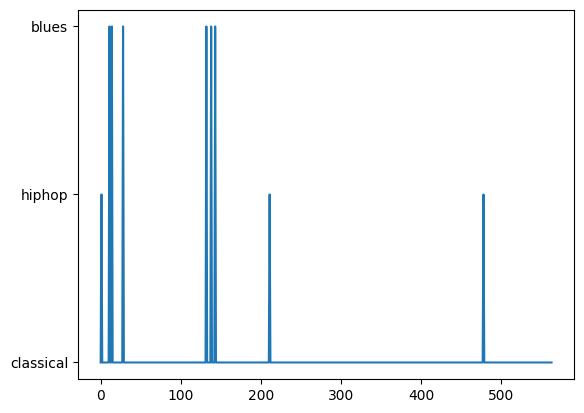

In [56]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
youtube_to_melgram("https://www.youtube.com/watch?v=TZCfydWF48c")
data = np.load('/content/youtube_melgrams.npy')
labels = data.shape[0]*['blues'] #dummy value
test = dataset(data, labels, labels_map, torch.tensor)
test_dataloader = DataLoader(test, batch_size=16,shuffle=False)
labels = infrence(test_dataloader, model)

data = np.load('/content/youtube_melgrams.npy')
actual = dataset(data, labels, labels_map, torch.tensor)
actual_dataloader = DataLoader(actual, batch_size=16,shuffle=False)

print("classical")
test_loss, f1_, acc_, confmatrix = evaluateCNN(test_dataloader,cost_func,model,device)
plt.plot(infrence(actual_dataloader, model))
print(f"Accuracy on Test dataloader is: {acc_} and f1 score is: {f1_}")

hiphop
Accuracy on Test dataloader is: 0.018691588785046728 and f1 score is: 0.011728056123323529


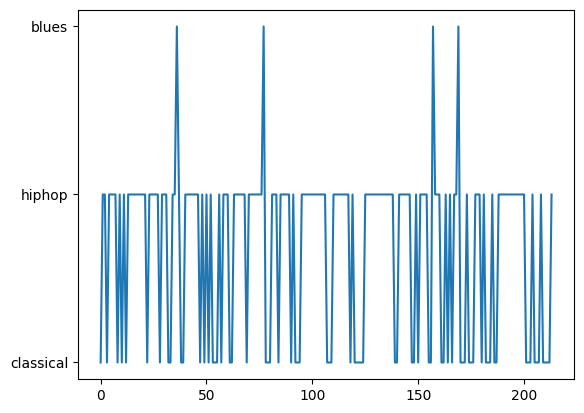

In [57]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data = youtube_to_melgram("https://www.youtube.com/watch?v=4EJzOk9csek")
data = np.load('/content/youtube_melgrams.npy')
labels = data.shape[0]*['blues'] #dummy value
test = dataset(data, labels, labels_map, torch.tensor)
test_dataloader = DataLoader(test, batch_size=16,shuffle=False)
labels = infrence(test_dataloader, model)

data = np.load('/content/youtube_melgrams.npy')
actual = dataset(data, labels, labels_map, torch.tensor)
actual_dataloader = DataLoader(actual, batch_size=16,shuffle=False)

print("hiphop")
test_loss, f1_, acc_, confmatrix = evaluateCNN(test_dataloader,cost_func,model,device)
plt.plot(infrence(actual_dataloader, model))
print(f"Accuracy on Test dataloader is: {acc_} and f1 score is: {f1_}")


rock
Accuracy on Test dataloader is: 0.006369426751592357 and f1 score is: 0.005994754612066184


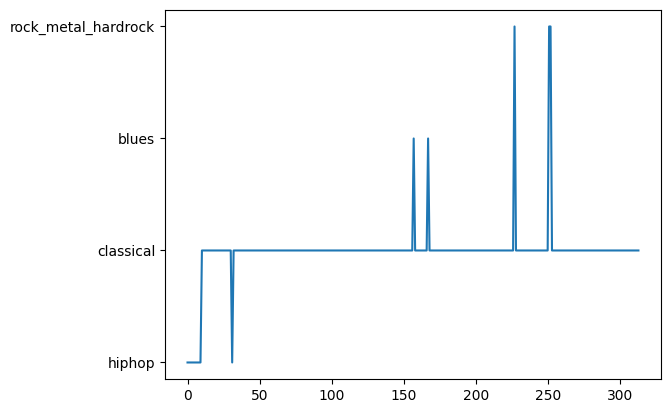

In [58]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data = youtube_to_melgram("https://www.youtube.com/watch?v=L7UMubmfbH0")
data = np.load('/content/youtube_melgrams.npy')
labels = data.shape[0]*['blues'] #dummy value
test = dataset(data, labels, labels_map, torch.tensor)
test_dataloader = DataLoader(test, batch_size=16,shuffle=False)
labels = infrence(test_dataloader, model)

data = np.load('/content/youtube_melgrams.npy')
actual = dataset(data, labels, labels_map, torch.tensor)
actual_dataloader = DataLoader(actual, batch_size=16,shuffle=False)

print("rock")
test_loss, f1_, acc_, confmatrix = evaluateCNN(test_dataloader,cost_func,model,device)
plt.plot(infrence(actual_dataloader, model))
print(f"Accuracy on Test dataloader is: {acc_} and f1 score is: {f1_}")



blues
Accuracy on Test dataloader is: 0.012738853503184714 and f1 score is: 0.008992132107922985


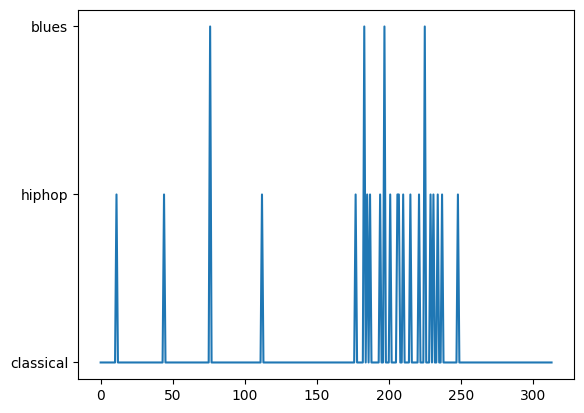

In [59]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data = youtube_to_melgram("https://www.youtube.com/watch?v=l45f28PzfCI")
data = np.load('/content/youtube_melgrams.npy')
labels = data.shape[0]*['blues'] #dummy value
test = dataset(data, labels, labels_map, torch.tensor)
test_dataloader = DataLoader(test, batch_size=16,shuffle=False)
labels = infrence(test_dataloader, model)

data = np.load('/content/youtube_melgrams.npy')
actual = dataset(data, labels, labels_map, torch.tensor)
actual_dataloader = DataLoader(actual, batch_size=16,shuffle=False)

print("blues")
test_loss, f1_, acc_, confmatrix = evaluateCNN(test_dataloader,cost_func,model,device)
plt.plot(infrence(actual_dataloader, model))
print(f"Accuracy on Test dataloader is: {acc_} and f1 score is: {f1_}")

Overall we observe that our model is predesposed to predicting "classical" over any other genre of music for the sample songs provided.
This can be attributed to bias during training or the overall modest performace a network achieves when tested with real world data (poor generalization).
Perhaps better regularisation would fix the issues as well as a bigger batch sizes.
We can conclude with certainty that Vivaldi composes classical music.
Another conclusion we reach is that Terror X Crew (TXC) incorporates a classical flair into their tunes, demonstrating an exquisite taste in their background sampling choices.
Sadly, I don't listen to a lot of blues songs so I used the recpmmended sample.
Lastly, we can safely conclude that Voodoo Child is a "classical" song more than a rock song, truly a masterpiece for the ages.